Import Libraries:

In [ ]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Define LSTM Model Function:

In [ ]:
# Function to build and compile the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(100, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(100, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Input Ticker Symbol:

In [ ]:
# Ask for stock ticker
ticker = input("Enter stock ticker: ")

Download and Preprocess Data:

In [ ]:
# Download data from Yahoo Finance
data = yf.download(ticker, start='2000-01-01')

# Save the downloaded data as a CSV file
data.to_csv(f"{ticker}_stock_data.csv", index=False)

# Extract the 'Close' prices
df = data[['Close']]
df.reset_index(inplace=True)

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set today's date
today = datetime(2023, 11, 6)

# Filter to only data before today
df = df[df['Date'] < today]

# Extract 'Close' prices
close_prices = df['Close'].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = scaler.fit_transform(close_prices.reshape(-1, 1))

[*********************100%%**********************]  1 of 1 completed


/var/folders/04/f0dssy990sl5y0pddk3yjsb80000gn/T/ipykernel_98431/1158776628.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


Prepare Training Data:

In [ ]:
# Prepare the data for training
X, y = [], []
look_back = 60  # Number of previous time steps to use for prediction

for i in range(len(close_prices) - look_back):
    X.append(close_prices[i:i+look_back])
    y.append(close_prices[i+look_back])

X, y = np.array(X), np.array(y)

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

 Build and Train the LSTM Model:

In [ ]:
# Build and compile the LSTM model
input_shape = (look_back, 1)
model = build_lstm_model(input_shape)

# Train the model for a reduced number of epochs (e.g., 10)
model.fit(X_train, y_train, batch_size=64, epochs=10)

Epoch 1/10
75/75 [==============================] - 10s 110ms/step - loss: 3.1964e-04
Epoch 2/10
75/75 [==============================] - 9s 114ms/step - loss: 2.3184e-05
Epoch 3/10
75/75 [==============================] - 9s 125ms/step - loss: 2.4572e-05
Epoch 4/10
75/75 [==============================] - 9s 127ms/step - loss: 2.0851e-05
Epoch 5/10
75/75 [==============================] - 9s 115ms/step - loss: 1.9458e-05
Epoch 6/10
75/75 [==============================] - 9s 121ms/step - loss: 2.0586e-05
Epoch 7/10
75/75 [==============================] - 9s 123ms/step - loss: 1.9989e-05
Epoch 8/10
75/75 [==============================] - 9s 121ms/step - loss: 1.6416e-05
Epoch 9/10
75/75 [==============================] - 9s 126ms/step - loss: 1.6830e-05
Epoch 10/10
75/75 [==============================] - 9s 117ms/step - loss: 1.6959e-05


Predict the Next Day's Stock Price:

In [ ]:
# Predict the next day's stock price
inputs = close_prices[-look_back:]
X_new = np.array([inputs])
X_new = np.reshape(X_new, (X_new.shape[0], X_new.shape[1], 1))
predicted_price = model.predict(X_new)
predicted_price = scaler.inverse_transform(predicted_price)

# Print the predicted price
tomorrow = today + timedelta(days=1)
print(f"Predicted close price for {ticker} on {tomorrow}: {predicted_price[0][0]:.2f}")

1/1 [==============================] - 0s 465ms/step
Predicted close price for AAPL on 2023-11-07 00:00:00: 165.41


Create a Table with Dates and Predicted Prices:

In [ ]:
# Create a table with dates and predicted prices
dates = df['Date'][-len(X_test):]
actual_prices = df['Close'][-len(X_test):]
predicted_prices = scaler.inverse_transform(model.predict(X_test))
table_data = {
    'Date': dates,
    'Actual Price': actual_prices,
    'Predicted Price': predicted_prices.reshape(-1)
}
table_df = pd.DataFrame(table_data)
table_df.head()

38/38 [==============================] - 1s 25ms/step


,Date,Actual Price,Predicted Price
4811,2019-02-19,42.732498,44.158382
4812,2019-02-20,43.007500,44.216755
4813,2019-02-21,42.764999,44.237049
4814,2019-02-22,43.242500,44.227833
4815,2019-02-25,43.557499,44.209267


Create a Line Chart for Visualization:

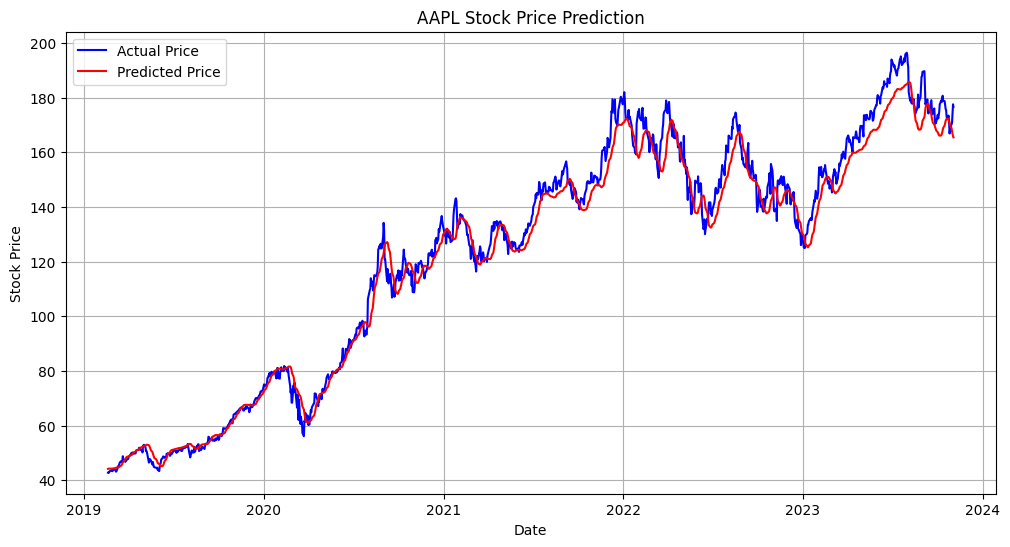

In [ ]:
# Create a line chart to visualize the actual and predicted prices
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_prices, label='Actual Price', color='blue')
plt.plot(dates, predicted_prices, label='Predicted Price', color='red')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()